In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import time
import random
import json
import gc

import numpy as np
import pandas as pd
import torch
import h5py
from ipywidgets import interact
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
import nibabel as nib
from einops import rearrange
from scipy import ndimage
from fracridge import FracRidgeRegressorCV

dir2 = os.path.abspath('../..')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: 
    sys.path.append(dir1)

In [2]:
# Load a clip model
import clip
device = "cuda" if torch.cuda.is_available() else "cpu"

print(clip.available_models())
model_name = 'ViT-B/32'
full_model, preprocess = clip.load(model_name, device=device)
model = full_model.visual

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']


In [3]:
from research.data.things_dataset import ThingsDataset

import torchvision.transforms as T
import torch.nn.functional as F

things_path = Path("X:\\Datasets\\EEG\\Things-concepts-and-images\\")
derivatives_path = Path('X:\\Datasets\\EEG\\Things-supplementary')
similarity_path = Path('X:\\Datasets\\EEG\\Things-similarity')

things_dataset = ThingsDataset(
    root=things_path,
    transform=preprocess,
    #supplementary_path="X:\\Datasets\\EEG\\Things-supplementary\\",
    #latent_name="bigbigan-resnet50",
)

In [4]:
nsd_path = Path('D:\\Datasets\\NSD\\')
results_path = nsd_path / f'derivatives/figures/things'
results_path.mkdir(exist_ok=True, parents=True)

In [ ]:
with h5py.File(Path(derivatives_path) / f'{model_name.replace("/", "=")}.hdf5', 'a') as f:
    N = len(things_dataset)
    E = 512
    dset = f.require_dataset('embedding', (N, E), np.float32)
    for i in tqdm(range(N)):
        image = things_dataset[i]['data']
        image = image[None].to(torch.float16)
        with torch.no_grad():
            embedding = model(image.to(device)).cpu().numpy()
        dset[i] = embedding[0]

In [ ]:
import scipy.io as sio
im_mat = sio.loadmat(similarity_path / 'variables' / 'im.mat')

In [ ]:
im_mat['im'][0

In [ ]:
im_mat.keys()
plt.imshow(im_mat['im'][0][0])

In [4]:
clip_embeddings = h5py.File(Path(derivatives_path) / f'ViT-B=32.hdf5', 'r')['embedding'][:]

In [5]:
clip_concept_embeddings = np.stack([
    clip_embeddings[things_dataset.image_concept_ids == i].mean(axis=0)
    for i in np.unique(things_dataset.image_concept_ids)
])
clip_concept_embeddings = clip_concept_embeddings / np.linalg.norm(clip_concept_embeddings, axis=1)[:, None]

In [ ]:
clip_concept_embeddings

In [6]:
things_embeddings = np.loadtxt(similarity_path / 'data' / 'spose_embedding_49d_sorted.txt')

In [7]:
from fracridge import FracRidgeRegressorCV
from sklearn.linear_model import LinearRegression, PoissonRegressor, RidgeCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split

Y = things_embeddings.astype(np.float32)
X = clip_concept_embeddings
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

model = RidgeCV(fit_intercept=False)
model.fit(X_train, Y_train)
Y_test_pred = model.predict(X_test)
model.score(X_test, Y_test)

0.5274187614645814

In [ ]:
Y_pred = model.predict(X_test)

In [12]:
@interact(i=(0, 48))
def show(i):
    plt.hist(Y_test_pred[:, i], bins=50)
    plt.show()

interactive(children=(IntSlider(value=24, description='i', max=48), Output()), _dom_classes=('widget-interact'…

In [ ]:
things_embeddings.min()

In [ ]:
Y_pred.shape

In [15]:
from research.metrics.metrics import r2_score




In [103]:
things_concepts = [
    'made of metal, artificial, hard', 
    'food-related, eating-related, kitchen-related',
    'animal-related, organic',
    'clothing-related, fabric, covering',
    'furniture-related, household-related, artifact',
    'plant-related, green',
    'outdoors-related',
    'transportation, motorized, dynamic',
    'wood-related, brownish',
    'body part-related',
    'colorful',
    'valuable, special occasion-related',
    'electronic, technology',
    'sport-related, recreational activity-related',
    'disc-shaped, round',
    'tool-related',
    'many small things, course pattern',
    'paper-related, thin, flat, text-related',
    'fluid-related, drink-related',
    'long, thin',
    'water-related, blue',
    'powdery, fine-scale pattern',
    'red',
    'feminine (stereotypically), decorative',
    'bathroom-related, sanitary',
    'black, noble',
    'weapon, danger-related, violence',
    'musical instrument-related, noise-related',
    'sky-related, flying-related, floating-related',
    'spherical, ellipsoid, rounded, voluminous',
    'repetitive',
    'flat, patterned',
    'white',
    'thin, flat',
    'disgusting, bugs',
    'string-related',
    'arms/legs/skin-related',
    'shiny, transparent',
    'construction-related, physical work-related',
    'fire-related, heat-related',
    'head-related, face-related',
    'beams-related',
    'seating-related, put things on top',
    'container-related, hollow',
    'child-related, toy-related',
    'medicine-related',
    'has grating',
    'handicraft-related',
    'cylindrical, conical'
]

things_concepts2 = [c.replace('-related', '') for c in things_concepts]

with torch.no_grad():
    W_things = full_model.encode_text(clip.tokenize(things_concepts).to(device))
W_things = W_things.cpu().numpy()

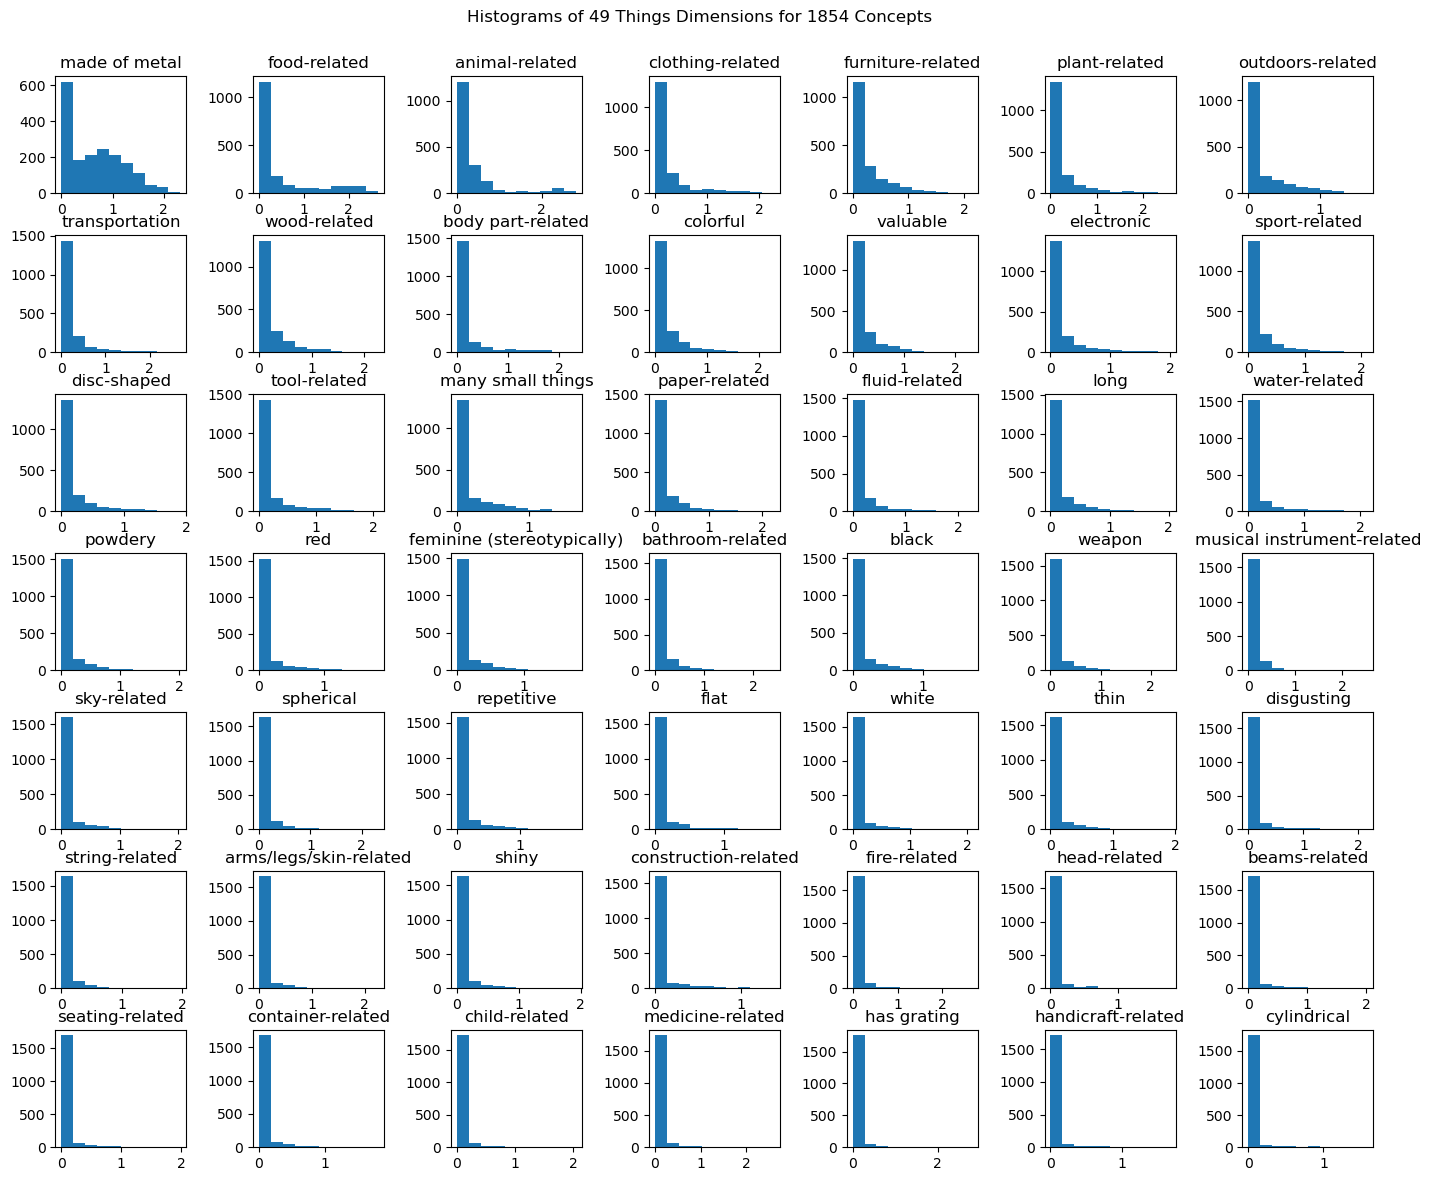

In [152]:
# R^2 histograms

fig, ax = plt.subplots(nrows=7, ncols=7, figsize=(14, 12), )
ax = ax.flatten()
fig.tight_layout()
fig.subplots_adjust(top=0.925,)

for i, things_concept in enumerate(things_concepts):
    ax[i].hist(Y[:, i])
    ax[i].set_title(things_concept.split(',')[0])


fig.suptitle('Histograms of 49 Things Dimensions for 1854 Concepts')
#fig.supxlabel('R^2')
#fig.supylabel('Number of Dimensions')
file_name = 'things_dimension_histograms.png'
plt.savefig(results_path / file_name, pad_inches=0)
plt.show()

In [ ]:
W_things.shape

In [ ]:
r2_score(torch.from_numpy(Y), torch.from_numpy(X @ W_things.T), reduction=None)

In [ ]:
.shape

In [ ]:
model.alpha_

In [97]:
hidden_size = 500

torch_model = torch.nn.Sequential(
    torch.nn.Linear(X.shape[1], Y.shape[1]),
    #torch.nn.LeakyReLU(),
    #torch.nn.Dropout(p=0.9),
    #torch.nn.Linear(hidden_size, hidden_size),
    #torch.nn.LeakyReLU(),
    #torch.nn.Dropout(p=0.9),
    #torch.nn.Linear(hidden_size, Y.shape[1]),
    torch.nn.ReLU()
)
torch_model = torch_model.cuda()

with torch.no_grad():
    torch_model[0].weight[:] = torch.from_numpy(model.coef_)

optim = torch.optim.Adam(torch_model.parameters(), lr=0.00001,)
criterion = torch.nn.MSELoss()

num_iterations = 5000
for i in range(num_iterations):
    torch_model.train()
    
    Y_train_pred = torch_model(torch.from_numpy(X_train).cuda())
    loss = criterion(torch.from_numpy(Y_train).cuda(), Y_train_pred)
    loss.backward()
    optim.step()
    
    if i % 250 == 0 or i == (num_iterations - 1):
        with torch.no_grad():
            torch_model.eval()
            
            torch_r2 = r2_score(
                torch.from_numpy(Y_test).cuda(), 
                torch_model(torch.from_numpy(X_test).cuda()), 
                reduction=None
            )
            print(i, torch_r2.mean().cpu().item())

0 0.5239845514297485
250 0.5369142889976501
500 0.5401908755302429
750 0.5419682860374451
1000 0.5441696047782898
1250 0.546416163444519
1500 0.5478262305259705
1750 0.5492964386940002
2000 0.5508555769920349
2250 0.5522516965866089
2500 0.5531339645385742
2750 0.5543866157531738
3000 0.5556861758232117
3250 0.5563845038414001
3500 0.5568146705627441
3750 0.5571922659873962
4000 0.5575155019760132
4250 0.5581702589988708
4500 0.5589482188224792
4750 0.5595126152038574
4999 0.5596438646316528


In [98]:
torch_model = torch_model.cpu()
with torch.no_grad():
    torch_model.eval()
    torch_r2 = r2_score(torch.from_numpy(Y_test), torch_model(torch.from_numpy(X_test)), reduction=None)
    print(torch_r2)

tensor([0.8821, 0.9467, 0.9317, 0.8413, 0.8068, 0.8150, 0.7439, 0.8726, 0.5757,
        0.8137, 0.5736, 0.6014, 0.8314, 0.7583, 0.4862, 0.7969, 0.4701, 0.7491,
        0.8122, 0.4839, 0.8292, 0.4459, 0.3075, 0.4994, 0.4875, 0.3681, 0.5693,
        0.5652, 0.5613, 0.5084, 0.3892, 0.4378, 0.2958, 0.4378, 0.6308, 0.5336,
        0.3032, 0.6228, 0.4196, 0.4480, 0.5497, 0.3917, 0.4590, 0.2086, 0.4709,
        0.4784, 0.2417, 0.1577, 0.0118])


In [57]:
r2 = r2_score(torch.from_numpy(Y_test), torch.from_numpy(model.predict(X_test)), reduction=None)

In [99]:
print((torch_r2 - r2).tolist())

[0.00814145803451538, 0.0031533241271972656, 0.008938908576965332, 0.004026651382446289, 0.006769716739654541, 0.012769758701324463, 0.016655147075653076, 0.027003467082977295, 0.03798395395278931, 0.029040157794952393, 0.03583937883377075, 0.0081939697265625, 0.03984332084655762, 0.03094637393951416, 0.045862168073654175, 0.02446722984313965, 0.021947205066680908, 0.034213364124298096, 0.03841620683670044, 0.023041844367980957, 0.03275686502456665, -0.0016613602638244629, 0.029389142990112305, 0.04299348592758179, 0.02374410629272461, 0.027385205030441284, 0.032619357109069824, 0.016737818717956543, 0.04525858163833618, 0.06415566802024841, 0.05501139163970947, 0.056425124406814575, 0.02928665280342102, 0.04917418956756592, 0.00684046745300293, 0.07750359177589417, -0.02051711082458496, 0.09501320123672485, 0.02969154715538025, 0.06763049960136414, 0.08088934421539307, 0.05539056658744812, 0.07334265112876892, -0.0003942251205444336, 0.07254436612129211, 0.07398372888565063, 0.0250531

In [69]:
r2.mean(), torch_r2.mean()

(tensor(0.5274), tensor(0.5072))

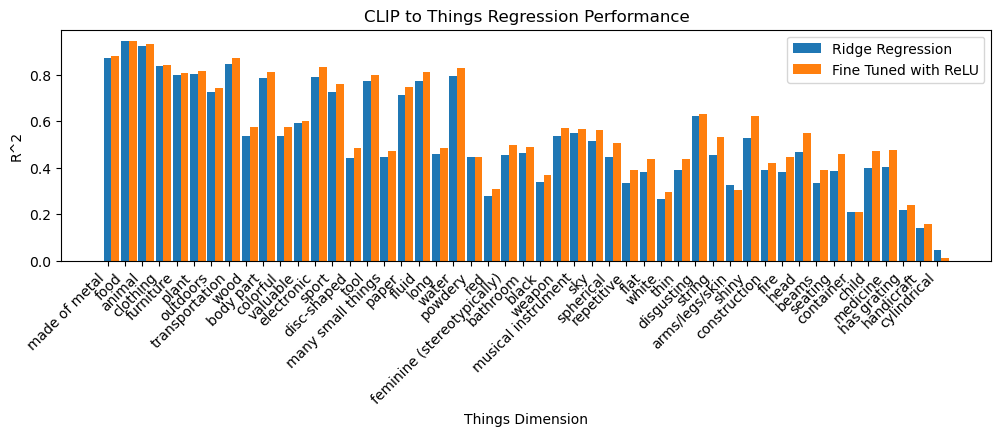

In [139]:
width = 0.45
plt.figure(figsize=(12, 3))
plt.title("CLIP to Things Regression Performance")
plt.xlabel("Things Dimension")
plt.ylabel("R^2")
plt.bar(np.arange(49), r2, 
        tick_label=[c.split(',')[0].replace('-related', '') for c in things_concepts], 
        width=width,
        label='Ridge Regression',)
plt.bar(np.arange(49) + width, torch_r2, width=width, label='Fine Tuned with ReLU')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.savefig(results_path / 'clip_to_things_r2.png', bbox_inches='tight')
plt.show()

In [160]:
ridge_weights = model.coef_
torch_weights = torch_model[0].weight[:].cpu().detach().numpy()

np.save(nsd_path / 'derivatives/things/ridge_weights.npy', ridge_weights)
np.save(nsd_path / 'derivatives/things/torch_weights.npy', torch_weights)

In [ ]:
np.save(nsd_path / 'derivatives/things/ridge_weights.npy', ridge_weights)
np.save(nsd_path / 'derivatives/things/torch_weights.npy', torch_weights)